In [11]:
# Imports
import torch
import torchvision                              # torch package for vision related things
import torch.nn.functional as F                 # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets         # Standard datasets
import torchvision.transforms as transforms     # Transformations we can perform on our dataset for augmentation
from torch import optim                         # For optimizers like SGD, Adam, etc.
from torch import nn                            # All neural network modules
from torchsummary import summary
from torch import Tensor
from torch.utils.data import DataLoader         # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm                           # For nice progress bar!

import os
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Union

Files already downloaded and verified
Files already downloaded and verified


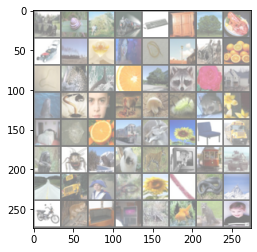

tensor(85) tensor(77) tensor(96) tensor(90) tensor(39) tensor(94) tensor(47) tensor(45) tensor(41) tensor(90) tensor(54) tensor(98) tensor(99) tensor(40) tensor(13) tensor(53) tensor(99) tensor(42) tensor(30) tensor(53) tensor(52) tensor(66) tensor(70) tensor(37) tensor(95) tensor(40) tensor(11) tensor(19) tensor(51) tensor(18) tensor(66) tensor(92) tensor(5) tensor(67) tensor(53) tensor(90) tensor(38) tensor(82) tensor(20) tensor(13) tensor(21) tensor(24) tensor(49) tensor(65) tensor(88) tensor(87) tensor(81) tensor(85) tensor(68) tensor(13) tensor(46) tensor(12) tensor(82) tensor(99) tensor(78) tensor(49) tensor(48) tensor(4) tensor(25) tensor(87) tensor(33) tensor(1) tensor(66) tensor(11)


In [12]:
################################################# datasets #################################################

# Path and Hyperparameters
#os.listdir('./drive/MyDrive/21-2-ML/')
storage = './drive/MyDrive/21-2-ML/CIFAR100/'

in_channels = 3
num_class   = 100
BS          = 64

# Apply Transformation : 
img_transformation = transforms.Compose([
                                         #transforms.RandomAffine(degrees=(-10,10), translate=(0, 0.05)),
                                         transforms.RandomHorizontalFlip(p = 0.5),
                                         transforms.ToTensor()
])

# Prepare the Dataset : 
train_data = datasets.CIFAR100(root = storage, train = True, transform = img_transformation, download = True)
test_data  = datasets.CIFAR100(root = storage, train = False, transform = img_transformation, download = True)
train_loader = DataLoader(dataset=train_data, batch_size=BS, shuffle=True)
test_loader  = DataLoader(dataset=test_data, batch_size=BS, shuffle=True)        # Shuffle for every epoch

# Check the prepared dataset : iter through the training loader
dataiter = iter(train_loader)
img, lab = dataiter.next()
def imshow(img):
    img = img / 2 + 0.5                                                          # unnormalize. Dataset images are already normalized!!
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# show images
imshow(torchvision.utils.make_grid(img))
# print labels
print(" ".join('%5s' % lab[j] for j in range(BS)))

In [13]:
print(lab.unique())  # Okay. labels are wetted properly.
print(img[0].shape)

tensor([ 1,  4,  5, 11, 12, 13, 18, 19, 20, 21, 24, 25, 30, 33, 37, 38, 39, 40,
        41, 42, 45, 46, 47, 48, 49, 51, 52, 53, 54, 65, 66, 67, 68, 70, 77, 78,
        81, 82, 85, 87, 88, 90, 92, 94, 95, 96, 98, 99])
torch.Size([3, 32, 32])


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Conv3x3 block
def conv3x3(in_ch, out_ch, stride = 1) ->nn.Conv2d:
    return nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
# Conv1x1 block
def conv1x1(in_ch, out_ch, stride = 1) ->nn.Conv2d:
    return nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False)

# Basic Residual block for ResNet 18 / 34
class ResBlock(nn.Module):
    expansion = 1
    def __init__(self, in_ch, out_ch, stride=1, downsample = None):
        super(ResBlock, self).__init__()
        # Sequential(residual fcn)
        self.residualBlock = nn.Sequential(
            conv3x3(in_ch, out_ch, stride=stride),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            conv3x3(out_ch, out_ch),
            nn.BatchNorm2d(out_ch)
        )
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out      = self.residualBlock(x)
        if self.downsample is not None:
            identity = self.downsample(x)
        out     += identity
        out     = nn.ReLU(inplace=True)(out)

        return out

# Bottleneck block for ResNet 50 / 101 / 152
class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_ch, out_ch, stride = 1, downsample = None):
        super(BottleNeck, self).__init__()
        self.residualBlock = nn.Sequential(
            conv1x1(in_ch, out_ch),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            conv3x3(out_ch, out_ch, stride=stride),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            conv1x1(out_ch, out_ch*BottleNeck.expansion),
            nn.BatchNorm2d(out_ch*BottleNeck.expansion)
        )
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out      = self.residualBlock(x)
        if self.downsample is not None:
            identity = self.downsample(x)
        out     += identity
        out     =  nn.ReLU(inplace=True)(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, n_layers, n_class = 100):
        super(ResNet, self).__init__()
        # The initial Conv layer
        self.in_ch  = 16
        self.conv   = conv3x3(3,16)
        self.BN     = nn.BatchNorm2d(16)
        self.relu   = nn.ReLU(inplace=True)
        # Blocks.
        self.layer1 = self.make_layer(block, 32, n_layers[0])
        self.layer2 = self.make_layer(block, 64, n_layers[1], stride=2)
        self.layer3 = self.make_layer(block, 128, n_layers[2], stride=2)
        self.layer4 = self.make_layer(block, 256, n_layers[3], stride=2)
        # Output layer elements
        self.pool   = nn.AdaptiveAvgPool2d((1,1))                     # The output size.
        self.fc1    = nn.Linear(256*block.expansion, n_class)
        self.drop   = nn.Dropout(p=0.5)

    def make_layer(self, block, out_ch, n_block, stride = 1):
        '''
        :param block:   block type, ResBlock or BottleNeck
        :param out_ch:  numbers of output channels
        :param n_block: number of blocks that will be stacked in the layer
        :param stride:  stride of the initial block of the layer.
        :return:        The entire ResNet model.
        '''
        downsample = None
        # Usage : for example, output of layer 1 shape = ( , 16, 32, 32)
        #         1) Here self.in_ch = 16
        #         2) out_ch of layer 2 = 32, hence downsample will be
        #            conv3x3(in = 16, out = 32, stride = 2) and added in the first block of the layer.
        if (stride!=1) or (self.in_ch!=out_ch):
            downsample = nn.Sequential(
                conv3x3(self.in_ch, out_ch*block.expansion, stride=stride),
                nn.BatchNorm2d(out_ch*block.expansion)
            )

        layers = []
        layers.append(block(self.in_ch, out_ch, stride, downsample)) # Add the block with downsample layer!
        self.in_ch = out_ch*block.expansion
        # Repeat blocks with the given list of numbers :
        for i in range(n_block):
            layers.append(block(self.in_ch, out_ch))
            self.in_ch = out_ch*block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.BN(out)
        out = self.relu(out)
        # Body
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Output
        out = self.pool(out)
        out = out.view(out.size(0), -1)
        out = self.drop(out)
        out = self.fc1(out)

        return out

def ResNet18():
    return ResNet(ResBlock, [2,2,2,2])

def ResNet34():
    return ResNet(ResBlock, [3,4,6,3])

def ResNet50():
    return ResNet(BottleNeck, [3,4,6,3])

def ResNet101():
    return ResNet(BottleNeck, [3,4,23,3])

def ResNet152():
    return ResNet(BottleNeck, [3,8,36,3])

test_X = torch.randn(12, 3, 32, 32).to(device)
model = ResNet50()
model = model.to(device)

out = model(test_X)
print(out.shape)
summary(model, (3,32,32), device = device.type)



torch.Size([12, 100])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]             512
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,216
       BatchNorm2d-8           [-1, 32, 32, 32]              64
         LeakyReLU-9           [-1, 32, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]           4,096
      BatchNorm2d-11          [-1, 128, 32, 32]             256
           Conv2d-12          [-1, 128, 32, 32]          18,432
      BatchNorm2d-13          [-1, 128, 32, 32]             256
       BottleNeck

In [16]:
'''model = ResNet(ResBlock, [3,3,3]).to(device)
X = torch.randn(16, 3, 32, 32).to(device)
output = model(X)
print(output.size(),'\n')
summary(model, (3,32,32), device=device.type)'''

"model = ResNet(ResBlock, [3,3,3]).to(device)\nX = torch.randn(16, 3, 32, 32).to(device)\noutput = model(X)\nprint(output.size(),'\n')\nsummary(model, (3,32,32), device=device.type)"

In [17]:
lr_init     = 0.0009


############################ Loss function and optimization #############################
loss_func = nn.CrossEntropyLoss(reduction = 'sum')                        # Sum-up the CE loss in the minibatch
optimizer = torch.optim.Adam(model.parameters(), lr = lr_init)

##################################### Lr scheduling #####################################
# print(optimizer.param_groups) All the layer weights.. and Hyperparameters!
from torch.optim.lr_scheduler import ReduceLROnPlateau
# patience : n epoch동안 loss reduction 없으면
# factor   : factor만큼 lr에 multplication함
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5)

######################### Function that calculates lr and loss ##########################
def get_lr(opt : optimizer) -> float:
    for param_group in opt.param_groups:
        return param_group['lr']

def batch_metric(prediction, target):                        # Returns correct number of data in a minibatch. 
    onehot_pred = prediction.argmax(1, keepdim = True)       # Extracts maximum prob. index
    corrects    = onehot_pred.eq(target.view_as(onehot_pred)).sum().item()
    # .sum() -> Tensor(scalar) --> .item()->scalar! 
    return corrects                                          # Therefore metric == accuracy, and passed trough scheduler

def batch_loss(loss_func, prediction, target, optim = None):
    loss     = loss_func(prediction, target)
    corrects = batch_metric(prediction, target)

    if optim is not None:           # In the training step
        optim.zero_grad()           # zero-initialize gradients(since pytorch sums-up gradients)
        loss.backward()                 # BP
        optim.step()                # https://tutorials.pytorch.kr/beginner/pytorch_with_examples.html
    return loss.item(), corrects    # loss.item() returns a scarlar value. 

In [18]:
###################### Get loss per epoch and return metric #######################
def loss_in_epoch(model, loss_func, train_dataloader, optimizer = None) -> int:
    running_loss = 0.0
    running_corrects = 0.0
    len_data = len(train_dataloader.dataset)  # .dataset = attibutes of the whole dataset.

    for X_batch, Y_batch in train_dataloader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        Y_pred  = model(X_batch)

        BatchLoss_train, corrects = batch_loss(loss_func, Y_pred, Y_batch, optimizer)
        running_loss             += BatchLoss_train
        #print(BatchLoss_train)

        if corrects is not None:
            running_corrects       += corrects

    loss   = running_loss / len_data          # Aggregate all losses in epoch -> divide to len(dataset)
    metric = running_corrects / len_data      # Aggregate all corrects in ''  -> divide to ''

    return loss, metric


################################ Training Function ################################
def train_model(model, params : dict) -> Union[model, dict, dict] :           # Multiple output annotation : Union[]
    # Assert parameters. 
    n_epoch     = params['n_epoch']
    optimizer   = params['optimizer']
    loss_func   = params['loss_func']
    train_dl    = params['train_dl']
    val_dl      = params['val_dl']
    lr_scheduler= params['lr_scheduler'] 

    # To store losses and accuracy:
    loss_history   = {'train' : [], 'val' : []}
    metric_history = {'train' : [], 'val' : []}

    # Record the best loss:
    best_loss = float('inf')
    
    start_time = time.time()
    for epoch in range(n_epoch):
        current_lr = get_lr(optimizer)
        print(f"Epoch [{epoch+1}/{n_epoch}], current lr = {current_lr:.8f}")

        model.train()
        train_loss, train_metric = loss_in_epoch(model, loss_func, train_dl, optimizer)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        with torch.no_grad():                                                 # Off all layers, i.e. stop update
            model.eval()                                                      # Since Dropout/norm.layers added, we turn off them in the eval.step. 
            val_loss, val_metric = loss_in_epoch(model, loss_func, val_dl)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)
        #if val_loss < best_loss : 
            # Here we aim to implement a storing function of the best model weights
         #   pass
        
        lr_scheduler.step(val_loss)                                           # Update lr_scheduler with metric = Accuracy
        print(f'training loss = {train_loss:.6f},  validation loss = {val_loss:.6f}, \
            accuracy = {100*val_metric:.4f},  time = {(time.time() - start_time):.3f} sec' )
        print('--'*10)

    return model, loss_history, metric_history

In [19]:
'''testlr = []
test_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
for i in range(100):
    optimizer.step()
    testlr.append(optimizer.param_groups[0]['lr'])
    #print(len(optimizer.param_groups))
    test_scheduler.step()      

plt.plot(range(100), testlr)'''


"testlr = []\ntest_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)\nfor i in range(100):\n    optimizer.step()\n    testlr.append(optimizer.param_groups[0]['lr'])\n    #print(len(optimizer.param_groups))\n    test_scheduler.step()      \n\nplt.plot(range(100), testlr)"

In [20]:
params_train = {'n_epoch'      : 50,
                'optimizer'    : optimizer,    # Adam(model.parameters(), lr = lr_init)
                'loss_func'    : loss_func,    # CrossEntropyLoss(reduction = 'sum')
                'train_dl'     : train_loader,
                'val_dl'       : test_loader,  # Here i use validation set as a test set. In practice, NEVER DO THIS!
                'lr_scheduler' : scheduler     # 
                }

model, loss_hist, metric_hist = train_model(model, params_train)

Epoch [1/50], current lr = 0.00090000
training loss = 3.988695,  validation loss = 3.496119,             accuracy = 16.3100,  time = 137.692 sec
--------------------
Epoch [2/50], current lr = 0.00090000
training loss = 3.078776,  validation loss = 2.841045,             accuracy = 30.1000,  time = 279.368 sec
--------------------
Epoch [3/50], current lr = 0.00090000
training loss = 2.470248,  validation loss = 2.226733,             accuracy = 41.2900,  time = 420.970 sec
--------------------
Epoch [4/50], current lr = 0.00090000
training loss = 2.120962,  validation loss = 2.069476,             accuracy = 45.4000,  time = 562.733 sec
--------------------
Epoch [5/50], current lr = 0.00090000
training loss = 1.816620,  validation loss = 1.863665,             accuracy = 49.4000,  time = 704.344 sec
--------------------
Epoch [6/50], current lr = 0.00090000
training loss = 1.607195,  validation loss = 1.609853,             accuracy = 54.8300,  time = 846.058 sec
--------------------
Epoc

In [25]:
PATH = './drive/MyDrive/21-2-ML/CIFAR100/Res18_CIFAR100_ckpt'

torch.save(model.state_dict(), PATH)        # Save the entire model
test_model = ResNet50().to(device)
test_model.load_state_dict(torch.load(PATH))
test_model.eval()

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (BN): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BottleNeck(
      (residualBlock): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.01, inplace=True)
        (6): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (downsample): Sequential(
        (0): Conv2d(16, 128, k

In [26]:
for i in range(20):
    n_accurate = 0 
    n_total    = 0

    # Sum of the accurate samples / Total test samples*100

    for X, Y in test_loader:
        n_total    += len(X)
        n_accurate += batch_metric(test_model(X.to(device)), Y.to(device))

    print(n_accurate/n_total*100)

68.13
68.0
67.85
68.35
67.96
68.16
67.88
68.27
68.05
67.97999999999999
68.05
68.44
68.5
68.21000000000001
68.41000000000001
67.97999999999999
68.24
68.06
67.96
68.19
